In [1]:
!pip install numpy scipy matplotlib scikit-learn


Tested: LR=0.01, Decay=0.8, Exp=0.5 -> AUC=0.6200000000000001
Tested: LR=0.01, Decay=0.8, Exp=1.0 -> AUC=0.4198717948717949
Tested: LR=0.01, Decay=0.8, Exp=1.5 -> AUC=0.54
Tested: LR=0.01, Decay=0.9, Exp=0.5 -> AUC=0.7873376623376624
Tested: LR=0.01, Decay=0.9, Exp=1.0 -> AUC=0.5487012987012987
Tested: LR=0.01, Decay=0.9, Exp=1.5 -> AUC=0.5608974358974358
Tested: LR=0.01, Decay=0.95, Exp=0.5 -> AUC=0.7149758454106281
Tested: LR=0.01, Decay=0.95, Exp=1.0 -> AUC=0.487012987012987
Tested: LR=0.01, Decay=0.95, Exp=1.5 -> AUC=0.43999999999999995
Tested: LR=0.05, Decay=0.8, Exp=0.5 -> AUC=0.7954911433172303
Tested: LR=0.05, Decay=0.8, Exp=1.0 -> AUC=0.6000000000000001
Tested: LR=0.05, Decay=0.8, Exp=1.5 -> AUC=0.5330882352941176
Tested: LR=0.05, Decay=0.9, Exp=0.5 -> AUC=0.7709359605911329
Tested: LR=0.05, Decay=0.9, Exp=1.0 -> AUC=0.6198686371100164
Tested: LR=0.05, Decay=0.9, Exp=1.5 -> AUC=0.45833333333333337
Tested: LR=0.05, Decay=0.95, Exp=0.5 -> AUC=0.6799999999999999
Tested: LR=0.05, 

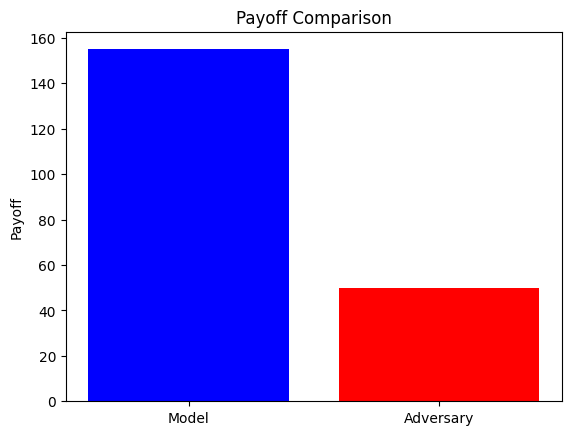

In [27]:
# REAL CODE
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Define the model class
class BayesianGameModel:
    def __init__(self, learning_rate=0.1, decay_factor=0.9, exploration_factor=1.0):
        # Model parameters
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor
        self.exploration_factor = exploration_factor
        self.beliefs = np.array([0.5, 0.5])  # Initial belief about the game
        self.payoffs = {"model": 0, "adversary": 0}

    def update_belief(self, outcome, action):
        """Update beliefs based on the outcome using Bayesian updating."""
        belief_update = self.learning_rate * (outcome - self.beliefs[action])
        self.beliefs[action] += belief_update
        # Apply decay to beliefs to capture temporal patterns
        self.beliefs = self.beliefs * self.decay_factor + np.array([1 - self.beliefs[0], self.beliefs[0]])

    def select_action(self):
        """Select action based on exploration-exploitation trade-off."""
        if np.random.rand() < self.exploration_factor:
            return np.random.choice([0, 1])  # Explore randomly
        else:
            return np.argmax(self.beliefs)  # Exploit the best-known action

    def simulate_round(self, action, adversary_action):
        """Simulate a round of the game with the current action and adversary's action."""
        # Payoff structure: change it to be more complex
        if action == 0 and adversary_action == 0:
            outcome = 1  # Both cooperated
            model_payoff = 3
            adversary_payoff = 3
        elif action == 0 and adversary_action == 1:
            outcome = 0  # Model cooperated, adversary defected
            model_payoff = 0
            adversary_payoff = 5
        elif action == 1 and adversary_action == 0:
            outcome = 0  # Model defected, adversary cooperated
            model_payoff = 5
            adversary_payoff = 0
        else:
            outcome = 1  # Both defected
            model_payoff = 1
            adversary_payoff = 1

        # Update payoffs
        self.payoffs["model"] += model_payoff
        self.payoffs["adversary"] += adversary_payoff
        return outcome, model_payoff, adversary_payoff

    def train(self, rounds=50):
        """Train the model over a set number of rounds."""
        outcomes = []
        adversary_actions = []

        for round_num in range(rounds):
            model_action = self.select_action()  # Select model's action
            adversary_action = np.random.choice([0, 1])  # Random adversary action
            outcome, _, _ = self.simulate_round(model_action, adversary_action)
            self.update_belief(outcome, model_action)
            outcomes.append(outcome)
            adversary_actions.append(adversary_action)
            #print(f"Round {round_num+1}: Model Belief={self.beliefs}, Model Action={model_action}, Outcome={outcome}")

        return outcomes, adversary_actions

# Hyperparameter tuning function
def optimize_hyperparameters():
    # Possible hyperparameter values to test
    learning_rates = [0.01, 0.05, 0.1, 0.2]
    decay_factors = [0.8, 0.9, 0.95]
    exploration_factors = [0.5, 1.0, 1.5]

    best_auc_score = 0
    best_params = None

    for lr in learning_rates:
        for decay in decay_factors:
            for exp in exploration_factors:
                # Train the model with the given hyperparameters
                model = BayesianGameModel(learning_rate=lr, decay_factor=decay, exploration_factor=exp)
                outcomes, adversary_actions = model.train(rounds=50)

                # Calculate AUC score for the current model
                auc_score = roc_auc_score(outcomes, adversary_actions)
                print(f"Tested: LR={lr}, Decay={decay}, Exp={exp} -> AUC={auc_score}")

                # Update best hyperparameters based on the highest AUC score
                if auc_score > best_auc_score:
                    best_auc_score = auc_score
                    best_params = {'learning_rate': lr, 'decay_factor': decay, 'exploration_factor': exp}

    print(f"Best Hyperparameters: {best_params} with AUC: {best_auc_score}")
    return best_params

# Evaluate the model performance
def evaluate_model(payoffs, y_true, y_pred):
    """
    Evaluate the model's performance using metrics like accuracy, AUC, and model-adversary payoff comparison.
    :param payoffs: Tuple containing (model_payoff, adversary_payoff)
    :param y_true: True labels for the validation/test set
    :param y_pred: Predicted labels for the validation/test set
    :return: None
    """

    # Extract payoffs
    model_payoff, adversary_payoff = payoffs

    # Calculate accuracy
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"Model Accuracy: {accuracy:.4f}")

    # Calculate AUC (Area Under the Curve)
    auc = roc_auc_score(y_true, y_pred)
    print(f"Model Robustness (AUC): {auc:.4f}")

    # Payoff comparison
    print(f"Model Payoff: {model_payoff}")
    print(f"Adversary Payoff: {adversary_payoff}")

    # Plot comparison between Model and Adversary Payoffs
    plt.bar(["Model", "Adversary"], [model_payoff, adversary_payoff], color=['blue', 'red'])
    plt.title("Payoff Comparison")
    plt.ylabel("Payoff")
    plt.show()

# Run hyperparameter optimization
best_params = optimize_hyperparameters()

# Run the model with the best parameters found
model = BayesianGameModel(
    learning_rate=best_params['learning_rate'],
    decay_factor=best_params['decay_factor'],
    exploration_factor=best_params['exploration_factor']
)

# Train the model for 50 rounds
outcomes, adversary_actions = model.train(rounds=50)

# Access the payoffs from the model object
model_payoff = model.payoffs["model"]
adversary_payoff = model.payoffs["adversary"]

# Example y_true and y_pred (for illustration; you should use your actual data)
y_true = outcomes  # True outcomes from training
y_pred = adversary_actions  # Adversary's actions (as predicted by the adversary)

# Print the final payoffs
print(f"Final Payoffs: Model Payoff={model_payoff}, Adversary Payoff={adversary_payoff}")

# Evaluate the model
evaluate_model((model_payoff, adversary_payoff), y_true, y_pred)
